In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import json
import os
import sys
sys.path.append(os.path.abspath(os.getcwd() + "./../"))
print(sys.path)

# load test dataset
from torch.utils.data import DataLoader
import json

import json
from tqdm import tqdm
import numpy as np
import os
import argparse

import torch
from torch import nn, optim
from torchvision import transforms as T
import json

from tasks.seq_mnist import SeqMNISTModelTraining_ntm, SeqMNISTParams_ntm, SeqMNISTModelTraining_lstm, SequentialMNIST
import json
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

['/Users/kerekmen/miniconda3/envs/s4/lib/python312.zip', '/Users/kerekmen/miniconda3/envs/s4/lib/python3.12', '/Users/kerekmen/miniconda3/envs/s4/lib/python3.12/lib-dynload', '', '/Users/kerekmen/miniconda3/envs/s4/lib/python3.12/site-packages', '/Users/kerekmen/Studium/Master/Semester2/NN/nn-seminar', '/Users/kerekmen/Studium/Master/Semester2/NN/nn-seminar', '/Users/kerekmen/Studium/Master/Semester2/NN/nn-seminar', '/Users/kerekmen/Studium/Master/Semester2/NN/nn-seminar', '/Users/kerekmen/Studium/Master/Semester2/NN/nn-seminar', '/Users/kerekmen/Studium/Master/Semester2/NN/nn-seminar']


## Plot losses

Sequence Length: 64


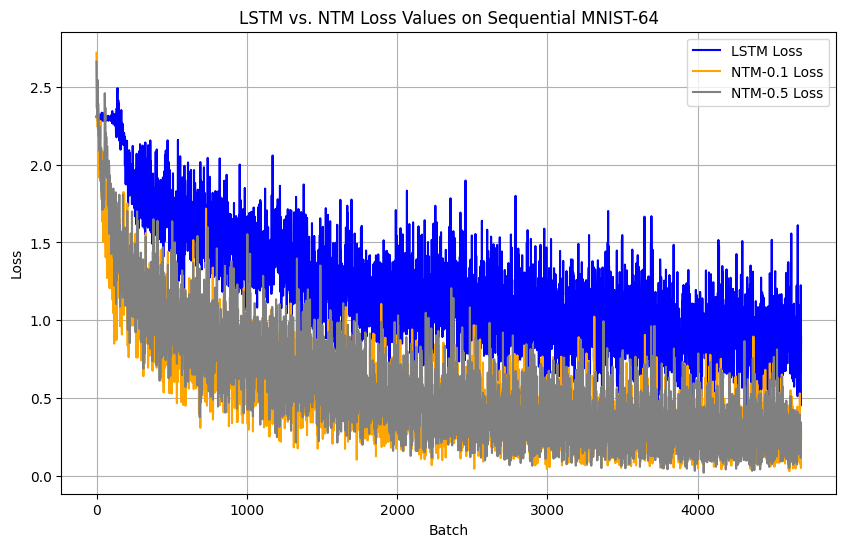

In [43]:
lstm_path_json = '../checkpoints/2024-06-1114-14-10/seq-mnist-lstm-64/seq-mnist-lstm--seed-1000-epoch-5-batch-937-2024-06-1114-14-10.json'
ntm_path_json = '../checkpoints/2024-06-1114-14-32/seq-mnist-ntm-64/seq-mnist-ntm--seed-1000-epoch-5-batch-937-2024-06-1114-14-32.json'
ntm_path_json2 = '../checkpoints/2024-06-1114-42-18/seq-mnist-ntm-64/seq-mnist-ntm--seed-1000-epoch-5-batch-937-2024-06-1114-42-18.json'

lstm_path_pt = os.path.splitext(lstm_path_json)[0] + '.pth'
ntm_path_pt = os.path.splitext(ntm_path_json)[0] + '.pth'
ntm_path_pt2 = os.path.splitext(ntm_path_json2)[0] + '.pth'


# Load the loss data from the JSON file
with open(lstm_path_json) as f:
    data_lstm = json.load(f)
with open(ntm_path_json) as f:
    data_ntm = json.load(f)
with open(ntm_path_json2) as f:
    data_ntm2 = json.load(f)

loss_lstm = data_lstm['loss']
loss_ntm = data_ntm['loss']
loss_ntm2 = data_ntm2['loss']

resolution = data_lstm["parameters_model"]["resize_resolution"]
sequence_len = resolution**2
print(f"Sequence Length: {sequence_len}")

# Define the window size for the rolling average
window_size = 400

# Adjust x to match the length of loss_avg
x_lstm = np.arange(len(loss_lstm))
x_ntm = np.arange(len(loss_ntm))
x_ntm2 = np.arange(len(loss_ntm2))

# plot both lstm and ntm losses on squential mnist
plt.figure(figsize=(10, 6))
plt.plot(x_lstm, loss_lstm, label='LSTM Loss', color='blue')
plt.plot(x_ntm, loss_ntm, label=f'NTM-{data_ntm["parameters_model"]["use_memory"]} Loss', color='orange')
plt.plot(x_ntm2, loss_ntm2, label=f'NTM-{data_ntm2["parameters_model"]["use_memory"]} Loss', color='grey')

plt.title(f'LSTM vs. NTM Loss Values on Sequential MNIST-{data_lstm["parameters_model"]["seq_len"]}')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Accuracy

Sequence Length: 64


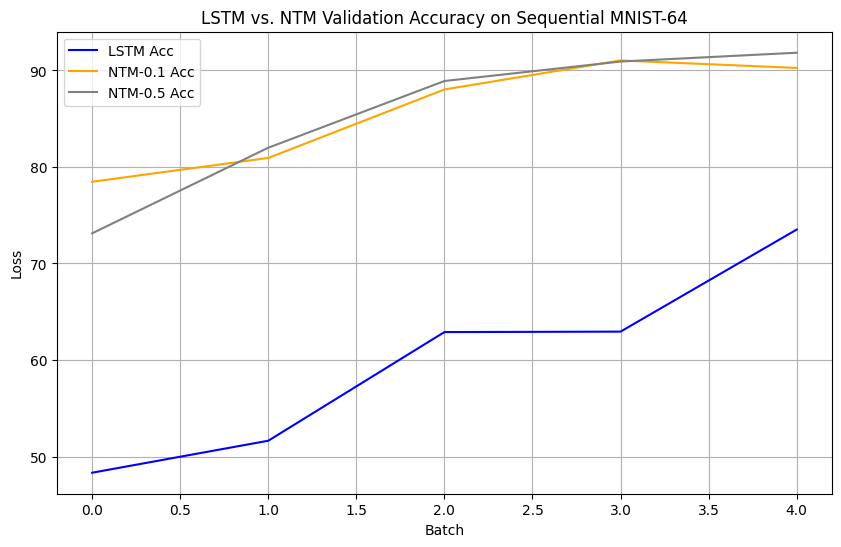

In [42]:
val_lstm = data_lstm['val_accuracy_list']
val_ntm = data_ntm['val_accuracy_list']
val_ntm2 = data_ntm2['val_accuracy_list']

resolution = data_lstm["parameters_model"]["resize_resolution"]
sequence_len = resolution**2
print(f"Sequence Length: {sequence_len}")

# Define the window size for the rolling average
window_size = 400

# Adjust x to match the length of loss_avg
x_lstm = np.arange(len(val_lstm))
x_ntm = np.arange(len(val_ntm))
x_ntm2 = np.arange(len(val_ntm2))

# plot both lstm and ntm losses on squential mnist
plt.figure(figsize=(10, 6))
plt.plot(x_lstm, val_lstm, label='LSTM Acc', color='blue')
plt.plot(x_ntm, val_ntm, label=f'NTM-{data_ntm["parameters_model"]["use_memory"]} Acc', color='orange')
plt.plot(x_ntm2, val_ntm2, label=f'NTM-{data_ntm2["parameters_model"]["use_memory"]} Acc', color='grey')
plt.title(f'LSTM vs. NTM Validation Accuracy on Sequential MNIST-{data_lstm["parameters_model"]["seq_len"]}')
plt.xlabel('Batch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# load test dataset
task_params = {
    "resize_resolution": resolution,
}
test_dataset = SequentialMNIST(task_params, train=False)

# load the model
lstm = SeqMNISTModelTraining_lstm()
ntm = SeqMNISTModelTraining_ntm()
lstm.net.load_state_dict(torch.load(lstm_path_pt))
ntm.net.load_state_dict(torch.load(ntm_path_pt))
print(len(test_dataset))

10000


# Run evaluation

In [36]:
from tqdm import tqdm

print(f"Number of samples: {len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=250, shuffle=False, )

dict_model = {
    "LSTM": lstm,
    "NTM": ntm
}

for model_name in dict_model:
    print(f"Testing model: {model_name}")
    model = dict_model[model_name]
    model.net.eval()
    correct = 0
    total = 0
    for i, (X, Y) in enumerate(tqdm(test_loader)):
        X = X.permute(1, 0, 2)
        Y = Y.squeeze(1)
        
        batch_size = X.size(1)
        if model_name == "NTM":
            model.net.init_sequence(batch_size)

        # Forward pass
        if model_name == "LSTM":
            y_out = model.net(X)
        else:
            for j in range(X.size(0)):
                y_out, _ = model.net(X[j])
        
        _, predicted = torch.max(y_out.data, 1)
        total += Y.size(0)
        correct += (predicted == Y).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

Number of samples: 10000
Testing model: LSTM


100%|██████████| 40/40 [00:06<00:00,  5.96it/s]


Accuracy: 74.51%
Testing model: NTM


100%|██████████| 40/40 [04:23<00:00,  6.58s/it]

Accuracy: 72.56%
